In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch 
import numpy as np
import ase 
from ase.io import read
import json  
from ase.units import Hartree

In [3]:
torch.set_default_dtype(torch.float64) # set default dtype of torch to avoid numerical errors 

# Instantiate the Molecule Dataset 

In [4]:
device = "cpu"

In [5]:
from mlelec.data.dataset import MoleculeDataset

/home/saade/miniconda3/envs/tutorial/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [6]:
molecule_data = MoleculeDataset(
    mol_name = "ethane",
    use_precomputed=True,
    path= "examples/data/ethane",
    aux_path="examples/data/ethane/sto-3g",
    frame_slice=slice(0, 200),
    device=device,
    aux=["overlap", "orbitals"],
    target=["fock", "dipole_moment"],
)


Loading structures
examples/data/ethane/sto-3g/fock.hickle
examples/data/ethane/sto-3g/dipole_moment.hickle


In [7]:
molecule_data.target

{'fock': tensor([[[-1.1029e+01, -2.9731e+00,  1.2640e-05,  ..., -7.2910e-02,
           -6.3063e-02, -6.5131e-02],
          [-2.9731e+00, -1.5699e+00, -3.8762e-02,  ..., -1.8520e-01,
           -1.7053e-01, -1.7014e-01],
          [ 1.2640e-05, -3.8762e-02, -3.3090e-01,  ..., -1.9624e-01,
           -1.8102e-01, -1.7205e-01],
          ...,
          [-7.2910e-02, -1.8520e-01, -1.9624e-01,  ..., -4.7172e-01,
           -2.6593e-01, -2.2374e-01],
          [-6.3063e-02, -1.7053e-01, -1.8102e-01,  ..., -2.6593e-01,
           -4.6759e-01, -2.5047e-01],
          [-6.5131e-02, -1.7014e-01, -1.7205e-01,  ..., -2.2374e-01,
           -2.5047e-01, -4.2164e-01]],
 
         [[-1.1027e+01, -2.9720e+00,  6.7050e-04,  ..., -7.8672e-02,
           -6.9593e-02, -6.0668e-02],
          [-2.9720e+00, -1.5558e+00, -2.5444e-02,  ..., -1.8914e-01,
           -1.8309e-01, -1.6513e-01],
          [ 6.7050e-04, -2.5444e-02, -3.2518e-01,  ..., -1.9451e-01,
           -1.8599e-01, -1.7927e-01],
          .

In [8]:
from mlelec.utils.learning_utils import compute_batch_dipole_moment, compute_dipole_moment_from_mf, instantiate_mf, compute_dipole_moment

Using PyTorch backend.


In [9]:
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol

In [10]:
mol=_instantiate_pyscf_mol(molecule_data.structures[0])

In [11]:
dm = mol.make_rdm1()

converged SCF energy = -78.2938178040352


In [12]:
basis = {6: [[1,0,0], [2,0,0], [2,1,-1], [2,1,0], [2,1,1]], 1: [[1,0,0]]}

In [13]:
frame = molecule_data.structures[0]

In [14]:
np.sum([len(basis[s]) for s in frame.numbers[0:3]])

11

In [15]:
natm = len(frame)
rho = np.zeros((natm, natm))
for i in range(8):
    i_start = int(np.sum([len(basis[s]) for s in frame.numbers[0:i]]))
    i_end = i_start + len(basis[frame.numbers[i]])
    for j in  range(8):
        j_start = int(np.sum([len(basis[s]) for s in frame.numbers[0:j]]))
        j_end = j_start + len(basis[frame.numbers[j]])
        rho[i,j] = np.sum(dm[i_start:i_end, j_start:j_end])

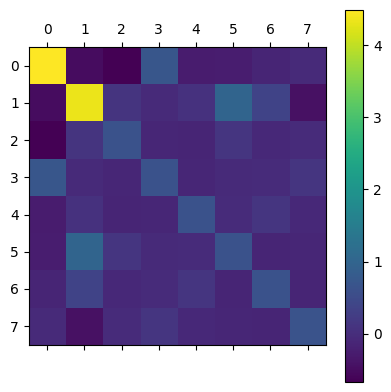

In [16]:
import matplotlib.pyplot as plt
plt.matshow(rho)
plt.colorbar()

### Create the ML dataset from the molecular data 

In [17]:
from mlelec.data.dataset import MLDataset

In [18]:
ml_data = MLDataset(
    molecule_data=molecule_data,
    device=device,
    model_strategy="coupled",
    shuffle=True, 
    shuffle_seed=5380,
)  

In [19]:
ml_data._split_indices(train_frac=0.7, val_frac=0.2, test_frac=0.1)

In [20]:
all_mfs, fockvars = instantiate_mf(
        ml_data,
        fock_predictions = molecule_data.target['fock'],
        batch_indices = list(range(len(ml_data.structures))),
    )


In [21]:
from mlelec.features.acdc import compute_features_for_target
from mlelec.data.dataset import get_dataloader

In [22]:
hypers = {
            "cutoff": 5.0,
            "max_radial" : 6,
            "max_angular": 4,
            "atomic_gaussian_width": 0.3,
            "center_atom_weight": 1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
        }

ml_data._set_features(compute_features_for_target(ml_data, device = device, hypers = hypers))

In [23]:
train_dl, val_dl, test_dl = get_dataloader(ml_data, model_return="tensor", batch_size=10)

# RidgeCV Model

In [24]:
from src.mlelec.models.linear import LinearTargetModel

### Fitting a RidgeCV model

In [25]:
model = LinearTargetModel(dataset = ml_data, nlayers = 1, nhidden = 16, bias = False, device = device)

In [26]:
pred_ridges, ridges = model.fit_ridge_analytical(set_bias=False)

### Calculating train and test errors for MO energies and dipoles

In [27]:
from mlelec.utils.twocenter_utils import _to_uncoupled_basis, _to_matrix, unfix_orbital_order
    
uncoupled = _to_uncoupled_basis(pred_ridges,  device=model.device) # Convert the coupled blocks to uncoupled

# Recover the predicted matrices for the training set 
fock_predictions_train = _to_matrix(
    uncoupled,
    ml_data.train_frames,
    ml_data.aux_data['orbitals'],
    device=model.device,
)

In [28]:
from typing import Optional, List, Union, Tuple, Dict

def isqrtm(A: torch.Tensor) -> torch.Tensor:
    eva, eve = torch.linalg.eigh(A)
    idx = eva > 1e-15
    return eve[:, idx] @ torch.diag(eva[idx] ** (-0.5)) @ eve[:, idx].T


def _lowdin_orthogonalize(
    fock: torch.Tensor, ovlp: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
    ovlp_i12 = isqrtm(ovlp)
    return torch.einsum("ij,jk,kl->il", ovlp_i12, fock, ovlp_i12)

In [29]:
# from mlelec.utils.twocenter_utils import _lowdin_orthogonalize

def compute_eigvals(ml_data, focks, indices):
    batch_frames = [ml_data.structures[i] for i in indices]
    batch_fock = unfix_orbital_order(
        focks, batch_frames, ml_data.molecule_data.aux_data["orbitals"]
    )
    batch_overlap = ml_data.molecule_data.aux_data["overlap"][indices]
    ortho_focks = [_lowdin_orthogonalize(f, o) for f, o in zip(batch_fock, batch_overlap)]
    eva = []
    for i in range(len(focks)):
        eva.append(torch.linalg.eigvalsh(ortho_focks[i]))
    return torch.stack(eva)

In [30]:
def compute_mulliken(ml_data, focks, indices):
    # We access the basis written as a dictionary from ml_data
    basis = ml_data.molecule_data.aux_data['orbitals']
    # We access the ase frames for each structure in the batch
    batch_frames = [ml_data.structures[i] for i in indices]
    # We access the Fock matrices for each structure in the batch
    batch_fock = unfix_orbital_order(
        focks, batch_frames, ml_data.molecule_data.aux_data["orbitals"]
    )
    # We access the overlap matrices for each structure in the batch
    batch_overlap = ml_data.molecule_data.aux_data["overlap"][indices]
    ortho_focks = [_lowdin_orthogonalize(f, o) for f, o in zip(batch_fock, batch_overlap)]
    
    eva = []
    rho_list = []
    for i in range(len(focks)):
        
        eval, mo_coeff = torch.linalg.eigh(ortho_focks[i])
        
        eva.append(eval)
        frame = batch_frames[i]
        
        # Define the single particle density matrix
        half_nelec = frame.numbers.sum() // 2
        mo_occ = torch.zeros(mo_coeff.shape[1])
        mo_occ[:half_nelec] = 2
        mocc = mo_coeff[:,mo_occ>0]
        #print(mo_coeff.shape)
        dm = (mocc*mo_occ[mo_occ>0]) @ (mocc.conj().T)
        
        natm = len(frame)
        rho = torch.zeros((natm, natm))
        for i in range(natm):
            i_start = int(np.sum([len(basis[s]) for s in frame.numbers[0:i]]))
            i_end = i_start + len(basis[frame.numbers[i]])
            for j in range(natm):
                j_start = int(np.sum([len(basis[s]) for s in frame.numbers[0:j]]))
                j_end = j_start + len(basis[frame.numbers[j]])
                rho[i,j] = torch.sum(dm[i_start:i_end, j_start:j_end])
        rho_list.append(rho)
        # rho_list.append(dm)
    return torch.stack(eva), torch.stack(rho_list)

In [31]:
# pred_eva = compute_eigvals(ml_data, fock_predictions_train, ml_data.train_idx)
eva = compute_eigvals(ml_data, ml_data.target.tensor[ml_data.train_idx], ml_data.train_idx)

In [32]:
ml_data.target.tensor[0:1].shape

torch.Size([1, 16, 16])

In [33]:
eva2, mull = compute_mulliken(ml_data, ml_data.target.tensor[0:2], torch.tensor([0,1]))

In [34]:
mull[0].numpy() / rho

array([[ 1.41836175,  0.3957422 ,  1.03971627,  1.72662807,  0.63876693,
        -0.00246312, -0.05796433,  0.05542491],
       [ 0.3957422 ,  1.44962324, -0.14478876,  0.07367843, -0.01647527,
         1.70168645,  2.18366302,  0.92149735],
       [ 1.03971627, -0.14478876,  1.52483129, -0.06257762, -0.17811697,
         0.66039733,  0.54116275,  0.47560976],
       [ 1.72662807,  0.07367843, -0.06257762,  1.55929795, -0.03861873,
         0.57138939,  0.62149293,  0.72136881],
       [ 0.63876693, -0.01647527, -0.17811697, -0.03861873,  1.55190433,
         0.57364723,  0.69605299,  0.57269794],
       [-0.00246312,  1.70168645,  0.66039733,  0.57138939,  0.57364723,
         1.55020576, -0.11170562, -0.01194663],
       [-0.05796433,  2.18366302,  0.54116275,  0.62149293,  0.69605299,
        -0.11170562,  1.53867067, -0.0976487 ],
       [ 0.05542491,  0.92149735,  0.47560976,  0.72136881,  0.57269794,
        -0.01194663, -0.0976487 ,  1.51957849]])

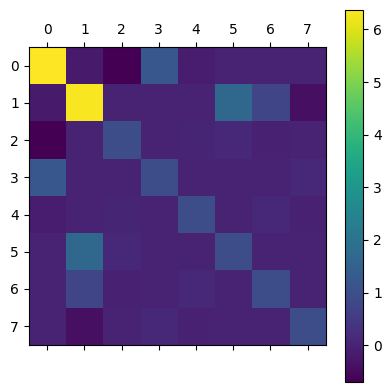

In [35]:
plt.matshow(mull[0])
plt.colorbar()

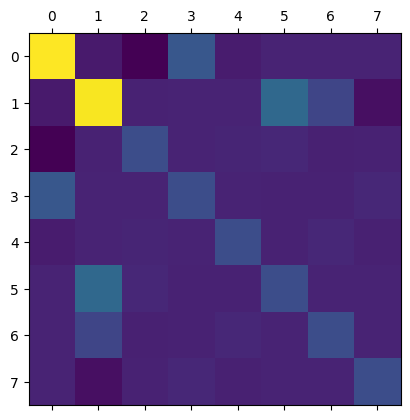

In [36]:
import matplotlib.pyplot as plt
plt.matshow(mull[0])

In [37]:
import mlelec.metrics as mlmetrics

loss_fn = getattr(mlmetrics, "L2_loss")
print("Train RMSE for MO_energies in eV: ", torch.sqrt(loss_fn(pred_eva, eva) / len(ml_data.train_idx) /16) *Hartree)

NameError: name 'pred_eva' is not defined

In [40]:
pred_test = model.predict_ridge_analytical(ml_data.target_test, ml_data.feat_test)

In [41]:
test_uncoupled = _to_uncoupled_basis(pred_test,  device=model.device) # Convert the coupled blocks to uncoupled
fock_predictions_test = _to_matrix(
test_uncoupled,
    ml_data.test_frames,
    ml_data.aux_data['orbitals'],
    device=model.device,
)

In [42]:
test_pred_eva = compute_eigvals(ml_data, fock_predictions_test, ml_data.test_idx)
test_eva = compute_eigvals(ml_data, ml_data.target.tensor[ml_data.test_idx], ml_data.test_idx)

print("Test RMSE for MO_energies in eV: ", torch.sqrt(loss_fn(test_pred_eva, test_eva) / len(ml_data.test_idx) /16) *Hartree)

Test RMSE for MO_energies in eV:  tensor(0.9743)


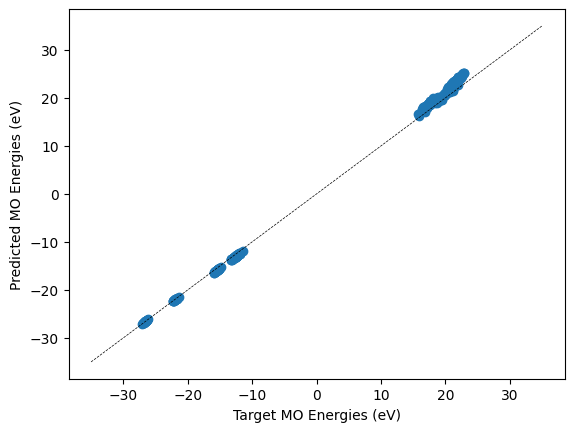

In [43]:
import matplotlib.pyplot as plt

x = test_eva * Hartree
y = test_pred_eva * Hartree

x = x[x>-50]
y = y[y>-50]
plt.scatter(x,y)

plt.plot([-35,35], [-35,35], linestyle='--', color='black', linewidth=0.5)
plt.xlabel('Target MO Energies (eV)')
plt.ylabel('Predicted MO Energies (eV)')
plt.show()

## Indirect learning of eigenvalues via bacprop

In [44]:
import os
os.environ["PYSCFAD_BACKEND"] = "torch"
import torch
from torch.autograd.functional import jacobian
from pyscf import gto
from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf
import pyscf.pbc.tools.pyscf_ase as pyscf_ase
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol
from mlelec.utils.twocenter_utils import fix_orbital_order, unfix_orbital_order
from tqdm import tqdm

In [45]:
# with io.capture_output() as captured:
#     all_mfs, fockvars = instantiate_mf(
#         ml_data,
#         fock_predictions=None,
#         batch_indices=list(range(len(ml_data.structures))),
#     )

In [46]:
from cmath import inf
best = inf
early_stop_criteria = 50

In [47]:
# Do this only if you want to start your indirect training from the Ridge fitted weights
train_pred = model.forward(ml_data.feat_train, return_type="tensor", batch_indices=ml_data.train_idx, ridge_fit=True)

In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=20, verbose=True
)

val_interval = 10
loss_fn = getattr(mlmetrics, "L2_loss") 
losses = []
losses_eval = []
losses_mull = []
early_stop_count = 0
nepochs = 800

/home/saade/miniconda3/envs/tutorial/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [49]:
iterator = tqdm(range(nepochs))

for epoch in iterator:
    model.train(True)
    train_loss = 0
    loss_eval_epoch = 0
    loss_mull_epoch = 0
    for data in train_dl:
        optimizer.zero_grad()
        idx = data["idx"]

        #forward pass
        pred = model(data["input"], return_type="tensor", batch_indices=idx)
        #pred_evals = compute_eigvals(ml_data, pred, data["idx"])
        #targ_evals = compute_eigvals(ml_data, ml_data.target.tensor[idx], data["idx"])
        pred_evals, pred_mull = compute_mulliken(ml_data, pred, data["idx"])
        targ_evals, targ_mull = compute_mulliken(ml_data, ml_data.target.tensor[idx], data["idx"])
        
        loss_eval = loss_fn(pred_evals, targ_evals) 
        loss_mull = loss_fn(pred_mull, targ_mull)
        
        loss = loss_eval + 0.001 * loss_mull
        
        loss_eval_epoch += loss_eval.item()
        loss_mull_epoch += loss_mull.item()
        # train_dip_pred = compute_batch_dipole_moment(
        #     ml_data, pred, batch_indices=idx, mfs=all_mfs
        # )
        # dip = torch.from_numpy(ml_data.molecule_data.target["dipole_moment"][idx].astype(np.float64))
        
        # loss = loss_fn(train_dip_pred, dip)
        train_loss += loss.item()
        
        # backward pass
        loss.backward(retain_graph = True)
        optimizer.step()
        
    losses_eval.append(loss_eval_epoch)
    losses_mull.append(loss_mull_epoch)
    losses.append(train_loss)
    scheduler.step(train_loss)
    
    model.train(False)

    if epoch % val_interval == 0:
        val_loss = 0
        for i, data in enumerate(val_dl):
            idx = data["idx"]
            val_pred = model(data["input"], return_type="tensor", batch_indices=idx)
            #val_pred_eval = compute_eigvals(ml_data, pred, data["idx"])
            #val_targ_eval = compute_eigvals(ml_data, ml_data.target.tensor[idx], data["idx"])
            val_pred_eval, val_pred_mull = compute_mulliken(ml_data, val_pred, data["idx"])
            val_targ_eval, val_targ_mull = compute_mulliken(ml_data, ml_data.target.tensor[idx], data["idx"])
            vloss = loss_fn(val_pred_eval, val_targ_eval) + 0.001 * loss_fn(val_pred_mull, val_targ_mull)
            
            # with io.capture_output() as captured:
            #     val_dip_pred = compute_batch_dipole_moment(
            #         ml_data, val_pred, batch_indices=idx, mfs=all_mfs
            #     )
            # val_dip = torch.from_numpy(ml_data.molecule_data.target["dipole_moment"][idx].astype(np.float64))
            # vloss = loss_fn(val_dip_pred, val_dip)
            val_loss += vloss.item()
        new_best = val_loss < best
        if new_best:
            best = val_loss
            # torch.save(model.state_dict(), 'best_model_dipole.pt')
            early_stop_count = 0
        else:
            early_stop_count += 1
        if early_stop_count > early_stop_criteria:
            print(f"Early stopping at epoch {epoch}")
            print(f"Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}")

            print(f"Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}")
            # Save last best model
            break

    if epoch % 1 == 0:
        iterator.set_postfix(train_loss = train_loss/len(ml_data.train_idx), 
                             Val_loss = val_loss/len(ml_data.val_idx),
                            eval_loss = loss_eval.item(), mull_loss = loss_mull.item())
        # print('loss_eval = ', loss_eval, 'loss_mull', loss_mull)
        

 32%|█████████████████████████████▌                                                              | 257/800 [1:17:56<2:44:40, 18.20s/it, Val_loss=0.0188, eval_loss=0.0324, mull_loss=153, train_loss=0.0184]


KeyboardInterrupt: 

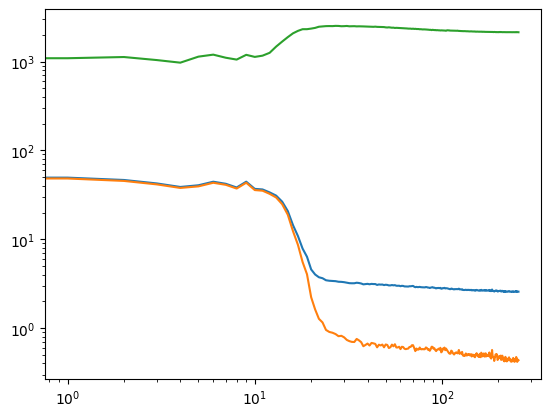

In [50]:
from matplotlib import pyplot as plt
plt.loglog(losses)
plt.loglog(losses_eval)
plt.loglog(losses_mull)

In [51]:
from IPython.utils import io

In [52]:
with io.capture_output() as captured:
    test_fock_predictions = model.forward(
        ml_data.feat_test, return_type="tensor", batch_indices=ml_data.test_idx,
    )

In [53]:
test_eva_pred_ind = compute_eigvals(ml_data, test_fock_predictions, ml_data.test_idx)
test_eva_ref = compute_eigvals(ml_data, ml_data.target.tensor[ml_data.test_idx], ml_data.test_idx)

In [54]:
error = loss_fn(test_eva_pred_ind, test_eva_ref) / len(ml_data.test_idx)
error

tensor(0.0032, grad_fn=<DivBackward0>)

In [55]:
print("Test RMSE on MO energies after indirect learning on eigenvalues {:.5f} eV ".format(torch.sqrt(error/16)*Hartree))

Test RMSE on MO energies after indirect learning on eigenvalues 0.38437 eV 


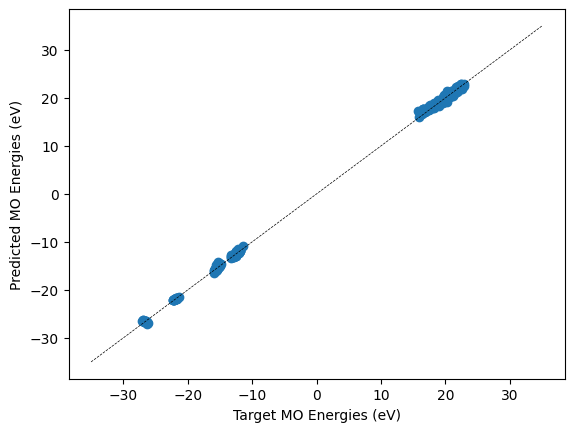

In [56]:
x = test_eva_ref.detach().numpy()  * Hartree
y = test_eva_pred_ind.detach().numpy()  * Hartree

x = x[x>-50]
y = y[y>-50]
plt.scatter(x,y)
    
plt.plot([-35,35], [-35,35], linestyle='--', color='black', linewidth=0.5)
plt.xlabel('Target MO Energies (eV)')
plt.ylabel('Predicted MO Energies (eV)')
plt.show()

In [57]:
test_eva_pred_ind, test_mull_pred_ind = compute_mulliken(ml_data, test_fock_predictions, ml_data.test_idx)
test_eva_ref, test_mull_ref = compute_mulliken(ml_data, ml_data.target.tensor[ml_data.test_idx], ml_data.test_idx)

In [58]:
loss_fn(test_mull_ref, test_mull_pred_ind)

tensor(316.3679, grad_fn=<SumBackward0>)

In [59]:
loss_fn(test_eva_ref, test_eva_pred_ind)

tensor(0.0670, grad_fn=<SumBackward0>)

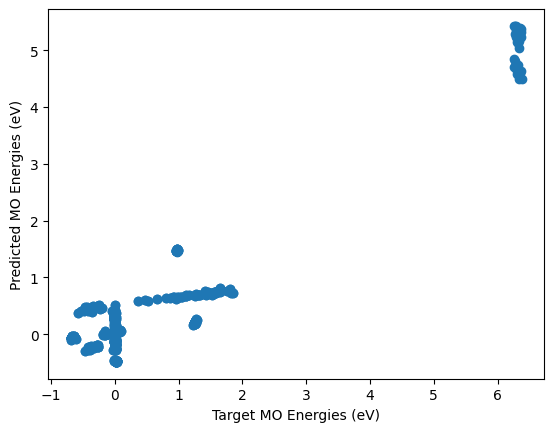

In [60]:
x = test_mull_ref.detach().numpy().flatten() # * Hartree
y = test_mull_pred_ind.detach().numpy().flatten() # * Hartree

# x = x[x>-50]
# y = y[y>-50]
plt.scatter(x,y)
    
# plt.plot([-35,35], [-35,35], linestyle='--', color='black', linewidth=0.5)
plt.xlabel('Target MO Energies (eV)')
plt.ylabel('Predicted MO Energies (eV)')
plt.show()

In [145]:
test_mull_ref

tensor([[[ 6.2662e+00, -3.8392e-01, -6.8756e-01,  ..., -1.7617e-02,
          -4.1061e-03,  1.4594e-02],
         [-3.8392e-01,  6.3313e+00,  5.9973e-03,  ...,  1.5910e+00,
           9.3225e-01, -3.4385e-01],
         [-6.8756e-01,  5.9973e-03,  9.7996e-01,  ...,  8.4897e-02,
          -2.6991e-02, -2.5924e-02],
         ...,
         [-1.7617e-02,  1.5910e+00,  8.4897e-02,  ...,  9.7424e-01,
           1.6591e-03,  6.9299e-03],
         [-4.1061e-03,  9.3225e-01, -2.6991e-02,  ...,  1.6591e-03,
           9.7846e-01,  2.1319e-02],
         [ 1.4594e-02, -3.4385e-01, -2.5924e-02,  ...,  6.9299e-03,
           2.1319e-02,  9.7722e-01]],

        [[ 6.3397e+00, -3.1986e-01, -6.9204e-01,  ..., -2.0389e-02,
           1.0360e-02,  3.1181e-03],
         [-3.1986e-01,  6.3674e+00, -6.5902e-03,  ...,  1.5198e+00,
           1.0329e+00, -4.3413e-01],
         [-6.9204e-01, -6.5902e-03,  9.7995e-01,  ...,  8.1410e-02,
          -1.9782e-02, -3.1511e-02],
         ...,
         [-2.0389e-02,  1